# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

**Group Members**
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

### A. Load Libraries

In [1]:
import numpy as np
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, OneHotEncoder
import tensorflow as tf
from sklearn.metrics import roc_curve, auc

### B. Load Data

In [2]:
# Load Data
train = pd.read_csv('../data/train_transaction.csv')
test = pd.read_csv('../data/test_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')
test_identity = pd.read_csv('../data/test_identity.csv')
sub = pd.read_csv('../data/sample_submission.csv').drop('isFraud', axis=1)

# II. Exploratory Data Analysis

### A. Background Info and Summary of Data

This competition involves the application of machine learning neural networks to determine fraudulent credit card transactions. The aim of the project is to train a model on credit card activity dataset from Vesta and use it to determine which transactions in the test data are likely to be fraudulent. This competition is hosted by IEEE-CIS (IEEE Computational Intelligence Society) and the Vesta corporation, the world's leading payment service company.  

The data comes primarily from Vesta in terms of 2 tables: the transaction table and the identity table:  

* The transaction table is a list of each transaction with attributes such as transaction ID, transaction amount, card issue company, product purchased, etc. Along with these, there are a large number of "masked" fields in which the data is masked/encoded or the column name is masked. We believe that these masked data fields contain valuable information like currency of transaction, latitude/longitude of transaction, etc. The transaction table has the important column `isFraud` which is 1 if the transaction is a fraud and is 0 if it is not. This is our target column. The transaction table is the primary table with 1.97m rows split into train and test dataset, having 590,540 rows and 506,691 rows.  

* Next, the Identity table is a much smaller table when compared to the transaction table. This table includes a number of fields that are masked/encoded because they provide identifying features. The Identity dataset has a total of 286k rows split into train and test datasets having 144,233 rows and 141,907 rows, respectively. The identity table rows can be mapped to the transaction table using the transactionID column.  

### B. First Look at the Data

This data is collected by Vesta’s fraud protection system and digital security partners (the sponsors of this competition).

In [3]:
tmp_dict = {
 name:{
    'Transactions': len(df), 
    'Features': len(df.columns),
    'Date Range': [floor(i / (60 * 60 * 24)) - 1 for i in (df['TransactionDT'].min(), df['TransactionDT'].max())] 
                  if 'TransactionDT' in df else '',
    }
 for df, name
 in zip(
   (train, test, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Transactions,590540,506691,144233,141907
Features,394,393,41,41
Date Range,"[0, 181]","[212, 394]",,


#### Takeaways  

* **Big Data**: We have over half a million records of card transactions in each of `train_transaction` and `test_transaction` datasets, and a maximum of 434 features to work with

- **Differing Transaction Date Ranges**: The transaction dates in `training_transaction` appear to cover a 181-day time period starting at day 0, while the transaction dates in `test_transaction` appear to cover a 182-day time period starting at day 212  
    - The training and test data do not overlap in time
    - Though the data publishers deliberately mask the dates of this data, we infer that Day 0 is June 1, 2018 based on timing of the competition the apparent choice to omit December as an outlier holiday month

### C. Missing Data

In [4]:
tmp_dict = {
 name:{
    'Percent of all Values that are Null': f'{(len(df) - df.count()).sum() / (df.shape[0] * df.shape[1]):.1%}',
    'Total Features': df.shape[1],
    'Features w/ Nulls': df.isnull().any().sum(),
    'Features w/ > 50% Nulls': (df.count() < (len(df) * 0.5)).values.sum(),
    'Features w/ > 80% Nulls': (df.count() < (len(df) * 0.2)).values.sum(),
    }
 for df, name
 in zip(
   (train, test, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Percent of all Values that are Null,41.1%,36.9%,35.6%,36.2%
Total Features,394,393,41,41
Features w/ Nulls,374,345,38,38
Features w/ > 50% Nulls,174,170,12,15
Features w/ > 80% Nulls,55,52,9,9


#### Takeaways  

* **Missing Data**: Almost all the columns include some portion of missing data.

### D. Outcome Variable - `isFraud`

In [5]:
print(f'Percent Fraudulent: {train.isFraud.sum() / len(train):.2%}')

Percent Fraudulent: 3.50%


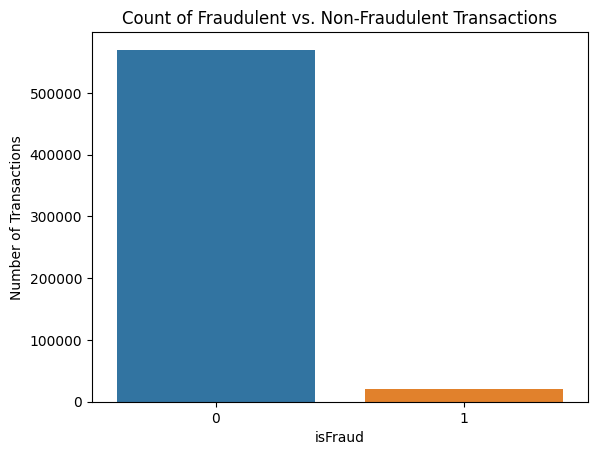

In [6]:
(sns.countplot(data=train, x='isFraud')
    .set(
     ylabel='Number of Transactions', 
     title='Count of Fraudulent vs. Non-Fraudulent Transactions'
     )
);

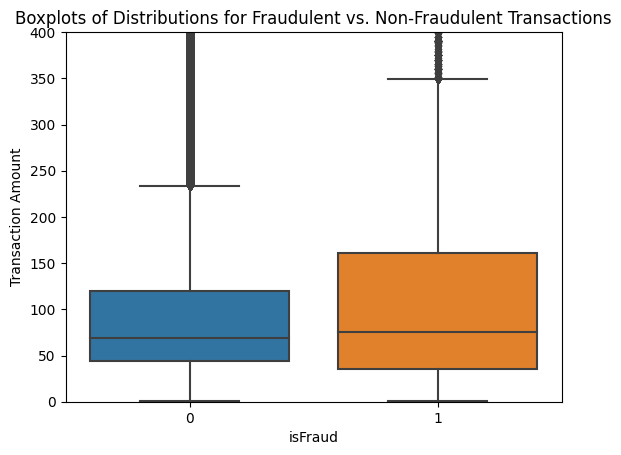

In [7]:
boxplot = sns.boxplot(data=train, x='isFraud', y='TransactionAmt')
boxplot.axes.axis(ymin=0, ymax=400)
boxplot.set_ylabel('Transaction Amount')
boxplot.set_title('Boxplots of Distributions for Fraudulent vs. Non-Fraudulent Transactions')
boxplot;

#### Takeaways  

* **Imbalanced Outcome Variable**: Only 3.5% of transactions are marked fraud, so we may want to account for this during training - we should be cautious of accuracy as a metric
    - One strategy: Downsample the majority class (i.e., not-fraud transactions) in the training data to build the model, then test the model against a normal test set.  


- **Difference in Transaction Amounts**: The distribution of fraudulent transactions appear to be somewhat greater than for the transactions not marked as fraud. This feature should be included in the model. 

### E. Identity Table

In [8]:
(train[['TransactionID']]
    .merge(train_identity.iloc[:,range(2)], on='TransactionID', how='left')
    .assign(have_identity=lambda df: ~pd.isna(df['id_01']))
    .groupby('have_identity')
    .count()
)

,TransactionID,id_01
have_identity,,
False,446307,0
True,144233,144233


#### Takeaways  

* The transactions in `train_identity` are a subset of the transactions in `train_transaction`, as is `test_identity` to `test_transaction` 
* About 25% of the transactions in `training_transaction` have a corresponding record in `training_identity`
* Because joining `training_identity` features to `training_transaction` will introduce a lot of `NULL` values, we will simply create a binary variable `have_identity` to indicate whether a transaction appears in both tables

### F. Transaction Datetime

Let's take a look at how the transaction datetime frequencies vary over time.

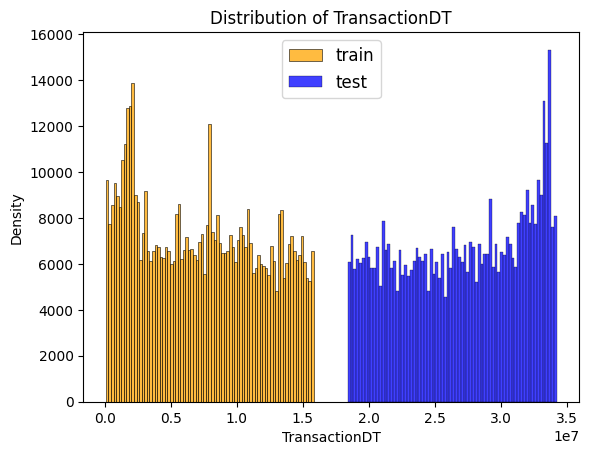

In [9]:
sns.histplot(train['TransactionDT'],  kde=False, label='train', color='orange')
sns.histplot(test['TransactionDT'],  kde=False, label='test', color='blue')
plt.legend(prop={'size': 12})
plt.title('Distribution of TransactionDT')
plt.xlabel('TransactionDT')
plt.ylabel('Density')
plt.show()

#### Takeaways  

* The train and test data appear to be two distinct time periods
    - Considering these are durations of seconds, that would make them each six month periods
* There is about a one-month gap between the two
* Test data has a spike around the end of the period, while training data has a spike near the beginning
* Note: We tried performing a time-based split of the training data to obtain our validation set - resulting model performed worse on our final Kaggle score
* Note: We tried extract a bunch of time features like isWeekend, isHoliday, but did not improve model

# III. Feature Engineering

### A. Custom Groupings for Purchaser and Recipient Domains

To use the purchaser and recipient domain email addresses, we create a highly customized categorical variable called `custom_domain_grouping`. 

This uses a switch statement to condense information about:

1. Drop the domain extensions so "gmail.com" and "gmail" are placed into same group
2. Whether recipient, purchaser, or both email addresses are null
3. Whether the recipient and purchaser domain address matched (e.g., gmail to gmail)
4. If the recipient and purchaser domain addresses do match, what domain is it?

In [10]:
def get_custom_domain_grouping(df_train, df_test):
    """This function is disgusting but gives us good categories from the domain addresses"""

    # Remove the domain extensions on all variables
    df_train['purch_domain_name'] = df_train.P_emaildomain.str.replace('\..*', '', regex=True)
    df_train['recip_domain_name'] = df_train.R_emaildomain.str.replace('\..*', '', regex=True)
    df_test['purch_domain_name'] = df_test.P_emaildomain.str.replace('\..*', '', regex=True)
    df_test['recip_domain_name'] = df_test.R_emaildomain.str.replace('\..*', '', regex=True)

    # Get the list of top 95% of email domains in the _training_ set only 
    top_95pct_purch_domains = (
        df_train.purch_domain_name
        .value_counts(normalize=True)
        .rename_axis('factor_levels')
        .cumsum()
        .reset_index(name='cumsum')
        .query('cumsum<0.95')
        .sort_values('cumsum')
        .factor_levels
        .tolist()   
    )
    
    # This switch statement is based on 
    custom_domain_grouping_train = np.select(
        condlist = [
            # Create a group for null recipients
            df_train.R_emaildomain.isnull(),
            # Create a group for null purchasers (when recipient not null)
            df_train.P_emaildomain.isnull(),
            # Create a group for purchaser domains paired with a distinct recipient domain
            df_train.purch_domain_name != df_train.recip_domain_name,
            # If domains match and in our most common domains 
            df_train.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_train.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    # Do the same as above, but for the test set
    custom_domain_grouping_test = np.select(
        condlist = [
            df_test.R_emaildomain.isnull(),
            df_test.P_emaildomain.isnull(),
            df_test.purch_domain_name != df_test.recip_domain_name,
            df_test.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_test.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    return custom_domain_grouping_train, custom_domain_grouping_test

train['custom_domain_grouping'], test['custom_domain_grouping'] = get_custom_domain_grouping(train, test)

### B. Whether Currency has More than Two Decimals

We create a new binary variable that indicates whether currency has more than two decimals, which suggests the purchase needed to be converted into USD.

In [11]:
def txn_usd_convert(amt):
    return np.float16(-Decimal(str(amt)).as_tuple().exponent > 2)

train['Transaction_curr_type'] = train['TransactionAmt'].apply(txn_usd_convert)
test['Transaction_curr_type'] = test['TransactionAmt'].apply(txn_usd_convert)

### C. Feature Engineering: User ID

Create a heuristic for User ID

In [12]:
train['uid'] = train['ProductCD'].astype(str) + '_' + \
  train['card1'].astype(str) + '_' + \
  train['card4'].astype(str) + '_' + \
  train['card6'].astype(str) + '_' + \
  train['addr1'].astype(str) + '_' + \
  train['dist1'].astype(str) + '_' + \
  train['dist2'].astype(str) + '_' + \
  train['P_emaildomain'].astype(str) + '_' + \
  train['C13'].astype(str)
train['uid'] = train['uid'].apply(lambda x: hash(x))

test['uid'] = test['ProductCD'].astype(str) + '_' + \
  test['card1'].astype(str) + '_' + \
  test['card4'].astype(str) + '_' + \
  test['card6'].astype(str) + '_' + \
  test['addr1'].astype(str) + '_' + \
  test['dist1'].astype(str) + '_' + \
  test['dist2'].astype(str) + '_' + \
  test['P_emaildomain'].astype(str) + '_' + \
  test['C13'].astype(str)
  
test['uid'] = test['uid'].apply(lambda x: hash(x))

# IV. Data Preparation

### A. Group the Columns

We define a lot of column sets for convenient subsetting features. Breaks down by numeric and categorical, and then type from there. 

In [13]:
# Transaction payment amount in USD
features_num_amt = train[['TransactionAmt']].columns

# Date and time of transactions
features_num_dt = train[['TransactionDT']].columns

# Distance measures between two masked points
features_num_dist = train.filter(regex='^dist').columns

# Various (masked) counts, e.g. how many addresses associated with payment card
features_num_C = train.filter(regex='^C').columns

# Various (masked) timedeltas, e.g. days between previous transactions
features_num_D = train.filter(regex='^D').columns

# Various (masked) Vesta engineered rich features
features_num_V = train.filter(regex='^V').columns

# uid
features_uid = train[['uid']].columns

features_num = (
    features_num_amt
    .union(features_num_dt)
    .union(features_num_dist)
    .union(features_num_C)
    .union(features_num_D)
    .union(features_num_V)
    .union(features_uid)
)

In [14]:
# Product code for the product associated with the transaction
features_cat_CD = train[['ProductCD']].columns

# Payment card information, such as card type, card category, issue bank, country
# features_cat_card = train.filter(regex='^card').columns
features_cat_card4 = train.filter(regex='^card4').columns
features_cat_card6 = train.filter(regex='^card6').columns

# Address (unspecified)
features_cat_addr = train.filter(regex='^addr').columns

# Purchaser and recipient email domains
features_cat_domain = train[['custom_domain_grouping']].columns

# Various matches (masked), e.g. names on card and addresses
features_cat_M = train.filter(regex='^M').columns

# New feature - whether the transaction amount had more than 2 decimal places
features_cat_curr_type = train[['Transaction_curr_type']].columns

features_cat = (
    features_cat_CD
    # .union(features_cat_card)
    .union(features_cat_card4)
    .union(features_cat_card6)
    .union(features_cat_addr)
    .union(features_cat_domain)
    .union(features_cat_M)
    .union(features_cat_curr_type)
)

In [15]:
# Define the sets of features used, by variable type 
features = features_num.union(features_cat)

# Define our ID column and target
id = train[['TransactionID']].columns
target = train[['isFraud']].columns

# Select relevant columns
train = train[target.union(features)]
test = test[features]

print(f'We start with {len(features)} available features: {len(features_num)} numeric and {len(features_cat)} categorical.')

We start with 389 available features: 373 numeric and 16 categorical.


### B. Split Data into Train and Validation

In [16]:
# Save 30% of the training data for validation
training, validation = train_test_split(train, test_size=0.3, random_state=1)

# With the remaining 70% in the training set, downsample the majority class
training = (
    training
    .groupby('isFraud')
    .sample(
        n=sum(training.isFraud == 1),
        random_state=1
    )
)

# Separate the features from the label
y_train = training[['isFraud']]
y_val = validation[['isFraud']]
X_train = training[features]
X_val = validation[features]

# Drop unneeded DataFrames
del training, validation

### C. Preprocessing

#### 1. Numeric Values - Replace N/A and Normalize

Apply Min-Max normalization and replace missing values for all numeric features in training, validation, and test sets

In [17]:
def replace_na_and_normalize(df, cols=features_num):
    return (df[cols]
        .apply(lambda var: var.fillna(var.min() - 2))
        .apply(minmax_scale, feature_range=(0,1))
    )

X_train[features_num] = replace_na_and_normalize(X_train)
X_val[features_num] = replace_na_and_normalize(X_val)
test[features_num] = replace_na_and_normalize(test)

#### 2. Categorical Values - Replace N/A and One-Hot Encode

Replace raw categorical features with one-hot encoding values

In [18]:
def get_one_hot_encoding(df, feature):
    # Instantiate the transformer
    ohe = OneHotEncoder()

    # Stack all datasets to get all unique categories observed
    categories = pd.concat([train[[feature]], test[[feature]]])

    # Fit the transformer with the observed classes
    ohe.fit(categories)

    # Create a sparse array with one binary vector per category
    transformed_array = ohe.transform(df[[feature]]).toarray()

    # Turn the transformed array into a DataFrame and assign names
    transformed_ndarray = pd.DataFrame(
        transformed_array,
        columns=ohe.get_feature_names_out(),
        index=df.index
    ).astype(np.float16)

    return transformed_ndarray

In [19]:
def replace_raw_cats_with_one_hots(df, cols=features_cat):
    # Initialize a placeholder list
    tmp_list = []

    # For each variable in our categorical features, get one-hot encoding matrix
    for var in features_cat:
        tmp_list.append(get_one_hot_encoding(df, var))

    # Convert list of DataFrames into one DataFrame of several sparse matrices
    tmp_df = pd.concat(tmp_list, axis=1)

    # Drop the raw categorical variables and replace with sparce matrices
    new_df = pd.concat([df.drop(features_cat, axis=1), tmp_df], axis=1)
    
    return new_df

In [20]:
# Carry out the one-hot encoding functions above for each data set
X_train = replace_raw_cats_with_one_hots(X_train)
X_val = replace_raw_cats_with_one_hots(X_val)
test = replace_raw_cats_with_one_hots(test)

# V. Fitting a Model

### A. Hyperparameters for Manual Tuning

In [21]:
HIDDEN_LAYER_SIZES = [512, 256, 256, 128]
HL_ACTIVATION = 'relu'
LEARNING_RATE = 0.0005
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LAMBDA = 0.05
DROPOUT_RATE = 0.5
NUM_EPOCHS = 64
BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.1

### B. Define Functions for Building the Model and Testing/Evaluation

In [22]:
def build_model():
  i=0
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  # INPUT LAYER
  model = tf.keras.Sequential()
  # HIDDEN LAYERS
  for hidden_layer_size in HIDDEN_LAYER_SIZES:
    if i == 0:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}'
      ))
    else:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}',
        kernel_regularizer=tf.keras.regularizers.L2(l2=LAMBDA)
      ))
    model.add(tf.keras.layers.BatchNormalization(name=f'batch_norm_{i}'))
    model.add(tf.keras.layers.Dropout(DROPOUT_RATE, name=f'dropout_{i}'))
    i+=1
  # OUTPUT LAYER
  model.add(tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid'))
  model.compile(
    loss='binary_crossentropy', 
    optimizer=OPTIMIZER, 
    metrics=[
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Precision(name='pre'),
      tf.keras.metrics.Recall(name='rec'),
      ]
  ) 
  return model

In [23]:
def train_and_evaluate(
  df_x_train=X_train,
  df_y_train=y_train,
  df_x_test=X_val,
  df_y_test=y_val
  ):

  # Build the model.
  model = build_model()

  # Train the model.
  print('Training...')

  history = model.fit(
    x=df_x_train,
    y=df_y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
    )
    
  # Retrieve training metrics (after each train epoch) and the final test accuracy
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(train_loss, label='train loss')
  plt.plot(val_loss, label='validation loss')
  plt.xticks(range(NUM_EPOCHS))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_metrics = model.evaluate(
    x=df_x_test,
    y=df_y_test,
    verbose=0,
    return_dict=True
    )
  
  return model, test_metrics

### C. Actually Train and Evaluate the Model

Training...
Epoch 1/64
26/26 [==============================] - 2s 42ms/step - loss: 33.7047 - auc: 0.6339 - pre: 0.5496 - rec: 0.5809 - val_loss: 27.8512 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.0909
Epoch 2/64
26/26 [==============================] - 1s 31ms/step - loss: 23.5968 - auc: 0.6881 - pre: 0.5930 - rec: 0.5972 - val_loss: 19.4629 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.0021
Epoch 3/64
26/26 [==============================] - 1s 30ms/step - loss: 16.2947 - auc: 0.7219 - pre: 0.6234 - rec: 0.6065 - val_loss: 13.5465 - val_auc: 0.0000e+00 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 4/64
26/26 [==============================] - 1s 32ms/step - loss: 11.1811 - auc: 0.7474 - pre: 0.6539 - rec: 0.6154 - val_loss: 9.4403 - val_auc: 0.0000e+00 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 5/64
26/26 [==============================] - 1s 31ms/step - loss: 7.6591 - auc: 0.7706 - pre: 0.6717 - rec: 0.6327 - val_loss: 6.6750 - val_auc: 0.0000e+00 - val_

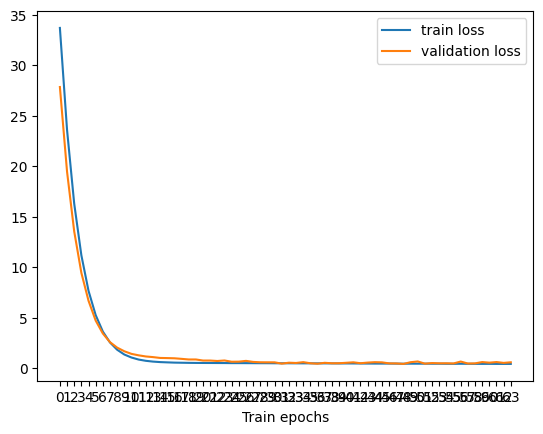

In [24]:
fit, test_metrics = train_and_evaluate()

#### Takeaways

* During training, our validation loss steeply dropped from 30 to below 1 in 16 epochs, then gradually converges to ½ by the 64th. 
* Over those same intervals, the validation recall jumps from less than 1% to 10%, then jumps to converge at 79%. 

In [25]:
fit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 512)               496128    
                                                                 
 batch_norm_0 (BatchNormaliz  (None, 512)              2048      
 ation)                                                          
                                                                 
 dropout_0 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 256)              1024      
 ation)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

# VI. Evaluating the Model

We will test our model against the 30% of the training data held-out for validation. Since we are doing binary classification, we care about loss (binary cross-entropy), AUC, precision, and recall. We also plot the ROC curve. 

In [26]:
pd.DataFrame({k:f'{v:.1%}' for k, v in test_metrics.items()}, index=[0])

,loss,auc,pre,rec
0,30.7%,88.8%,20.7%,68.4%


5537/5537 [==============================] - 7s 1ms/step


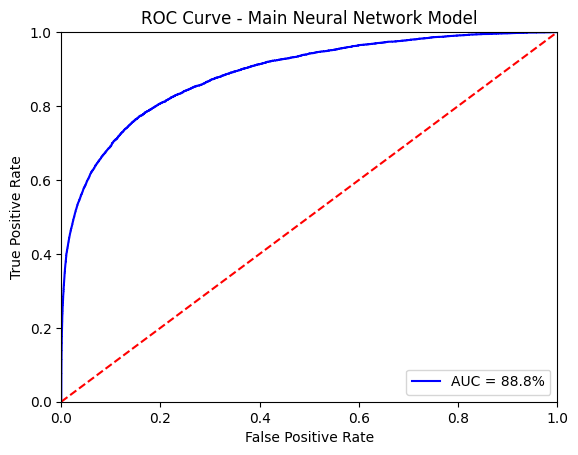

In [27]:
fpr, tpr, threshold = roc_curve(y_val, fit.predict(X_val))

plt.plot(fpr, tpr, 'b', label = f'AUC = {test_metrics["auc"]:.1%}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - Main Neural Network Model')
plt.show()

#### Takeaways

* We see a pretty healthy ROC curve with an area-under-the-curve of 88.8%. 

# VII. Outputting Model

Fit our model onto the unlabelled test data, then output as CSV we can upload to Kaggle.

In [28]:
sub['isFraud'] = fit.predict(test)
sub.to_csv('../data/submissions/main_neural_network_submission.csv', index=False)

15835/15835 [==============================] - 23s 1ms/step
